In [40]:
import numpy as np
import sympy

# s = np.int64(input("Please enter the degree of predictor-corrector method you want to be calculated: "))
s = 1
m = 1
t = sympy.symbols('t')
P = sympy.Function('P')(t, s, m)
def P(t,s,m):
    res = 1
    for l in range(s):
        if l!= m:
            res*= (t+s-1-l)/(m-l)
    return res
Q = sympy.Function('Q')(t, s, m)
def Q(t,s,m):
    res = 1
    # This loop could be from 1 to s or 0 to s-1, I chose the latter
    for l in range(s):
        if l!= m:
            res*= (t+s-2-l)/(m-l)
    return res

# This Function Collects the Adams-Bashforth and Adams-Moulton coefficients
def abm_coef_collector(s):
    # 'p's are the polynomial interpolations of the predictor
    p = sympy.symarray(('p'), shape=s)
    b = sympy.symarray(('b'),shape=s)
    # 'q's are the polynomial interpolations of the corrector
    q = sympy.symarray(('q'), shape=s)
    c = sympy.symarray(('c'),shape=s)
    bnum = np.zeros(s).reshape((1,s))
    bdenom = np.zeros(s).reshape((1,s))
    cnum = np.zeros(s).reshape((1,s))
    cdenom = np.zeros(s).reshape((1,s))
    ab = np.zeros(s).reshape((1,s))
    abm = np.zeros(s).reshape((1,s))
    for m in range(s):
        p[m]=P(t,s,m)
        b[m]=sympy.Rational(sympy.integrate(p[m],[t,0,1]).simplify())
        bnum[0,m] = b[m].numerator
        bdenom[0,m] = b[m].denominator
        q[m]=Q(t,s,m)
        c[m]=sympy.Rational(sympy.integrate(q[m],[t,0,1]).simplify())
        cnum[0,m] = c[m].numerator
        cdenom[0,m] = c[m].denominator
        ab[0,m] = 1.*np.int64(bnum[0,m])/np.int64(bdenom[0,m])
        abm[0,m] = 1.*np.int64(cnum[0,m])/np.int64(cdenom[0,m])
    return ab,abm,bnum,bdenom,cnum,cdenom

global one_sixth
one_sixth = 1./6
# Kuramoto Dynamics RHS of the equation
def func(Theta,w0,N,k):
    theta = Theta.reshape((1,N))
    res = np.ones_like(theta)*w0
    for i in range(N):
        res[0,i] += k*np.sum(np.sin(theta[0,:]-theta[0,i]),axis = 0)
    return res

def rk4_step(Theta,w0,N,k,dt):
    rk1 = func(Theta,w0,N,k)
    rk2 = func(Theta + 0.5*dt*rk1,w0,N,k)
    rk3 = func(Theta + 0.5*dt*rk2,w0,N,k)
    rk4 = func(Theta + dt*rk3,w0,N,k)
    res = Theta + one_sixth*(rk1+2*(rk2+rk3)+rk4)
    return res, rk1

def ab_step(dt,Theta_dot_History, ab):
    res = np.dot(ab,Theta_dot_History)*dt
    return res

def abm_step(dt,Theta_dot_History, ab, abm,s):
    dummy = Theta_dot_History
    for i in range(s-1):
        dummy[i,:] = dummy[i+1,:]
    dummy[s-1,:] = np.dot(ab,Theta_dot_History)*dt
    res = np.dot(abm,dummy)*dt
    return res

def initiate_kuramoto(N,omega0,K,dt,s):    
    # Initiating the phases as a splay with random fluctuation
    Theta0 = np.arange(0., 2*np.pi, 2*np.pi/N).reshape((1,N))+np.random.uniform(0.,1.,N).reshape((1,N))*1.0e-010
    Theta = np.zeros_like(Theta0)
    Theta_dot = np.zeros_like(Theta0)
    Theta_History = np.zeros((s,N))
    Theta_dot_History = np.zeros((s,N))
    #Creating the history
    Theta_History[0,:] = Theta0[0,:]
    k = 1.*N/K
    for i in range(s-1):
        Theta_History[i+1,:], Theta_dot_History[i,:] = rk4_step(Theta_History[i,:],omega0,N,k,dt)
    Theta = Theta_History[s-1,:]
    Theta_dot_History[s-1,:] = func(Theta,omega0,N,k)
    Theta_dot = Theta_dot_History[s-1,:]
    return Theta0,Theta,Theta_dot,Theta_History,Theta_dot_History,k

def Kuramoto(Final_Time,N,omega0,K,step_num,method,s):
    dt = 1./step_num
    Number_of_Steps = np.int64(Final_Time*step_num)
    Time = np.linspace(-(s-1)*dt,Final_Time,Number_of_Steps+s)
    Re_R = np.zeros(Number_of_Steps+s)
    Im_R = np.zeros(Number_of_Steps+s)
    rho = np.zeros(Number_of_Steps+s)
    global k
    Theta0,Theta,Theta_dot,Theta_History,Theta_dot_History,k = initiate_kuramoto(N,omega0,K,dt,s)
    for i in range(s):
        Re_R[i] = np.sum(np.cos(Theta_History[i,:]),axis=0)/N
        Im_R[i] = np.sum(np.sin(Theta_History[i,:]),axis=0)/N
    if method=="rk4":
        for i in range(Number_of_Steps):
            Theta, Theta_dot = rk4_step(Theta,omega0,N,k,dt)
            for j in range(s-1):
                Theta_History[j,:] = Theta_History[j+1,:]
                Theta_dot_History[j,:] = Theta_dot_History[j+1,:]
            Theta_History[s-1,:] = Theta
            Theta_dot_History[s-1,:] = Theta       
            Re_R[i+s] = np.sum(np.cos(Theta_History[s-1,:]),axis=0)/N
            Im_R[i+s] = np.sum(np.sin(Theta_History[s-1,:]),axis=0)/N            
    elif method=="ab":
        for i in range(Number_of_Steps):
            Theta = ab_step(dt,Theta_dot_History)
            Theta_dot = func(Theta,omega0,N,k)
            for j in range(s-1):
                Theta_History[j,:] = Theta_History[j+1,:]
                Theta_dot_History[j,:] = Theta_dot_History[j+1,:]
            Theta_History[s-1,:] = Theta
            Theta_dot_History[s-1,:] = Theta       
            Re_R[i+s] = np.sum(np.cos(Theta_History[s-1,:]),axis=0)/N
            Im_R[i+s] = np.sum(np.sin(Theta_History[s-1,:]),axis=0)/N                    
    elif method=="abm":
        for i in range(Number_of_Steps):
            Theta = abm_step(dt,Theta_dot_History)
            Theta_dot = func(Theta,omega0,N,k)
            for j in range(s-1):
                Theta_History[j,:] = Theta_History[j+1,:]
                Theta_dot_History[j,:] = Theta_dot_History[j+1,:]
            Theta_History[s-1,:] = Theta
            Theta_dot_History[s-1,:] = Theta          
            Re_R[i+s] = np.sum(np.cos(Theta_History[s-1,:]),axis=0)/N
            Im_R[i+s] = np.sum(np.sin(Theta_History[s-1,:]),axis=0)/N            
    else:
        print("Invalid Method!!!")
    rho = np.sqrt(np.multiply(Re_R,Re_R)+np.multiply(Im_R,Im_R))
    # phi = np.tan(np.divide(Im_R,Re_R))
    return rho,Re_R,Im_R,Time


In [41]:
ab,abm,bnum,bdenom,cnum,cdenom = abm_coef_collector(6)

In [42]:
rho,Re_R,Im_R,Time = Kuramoto(100.,12,np.pi/2,1.,100,"rk4",6)

(1, 12)


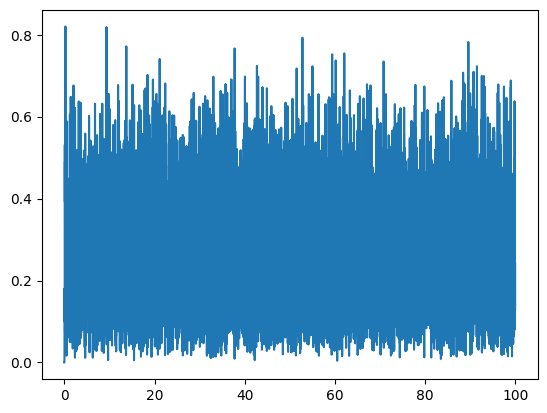

In [43]:
import matplotlib.pyplot as plt
plt.plot(Time,rho)

In [22]:
rho[-1]

0.0